# Flight Price Prediction: Data-Driven Insights into Airline Pricing

## Overview
Airline ticket prices fluctuate due to multiple factors, including demand, route popularity, seasonality, and competitive pricing strategies. This project explores how **machine learning models (Random Forest, XGBoost, etc.)** can predict flight prices based on various features.

## Objectives
- Analyze historical flight price data to identify key **pricing patterns**.
- Use **exploratory data analysis (EDA)** to uncover insights into factors affecting price variation.
- Build **predictive models** using SQL for data extraction, and ML techniques like Random Forest and XGBoost.
- Interpret model performance and discuss **real-world applicability**.

## Key Steps
1. **Data Loading & Exploration** – Understanding dataset structure, missing values, and statistical summaries.
2. **Feature Engineering** – Creating meaningful features to enhance model performance.
3. **Model Training & Evaluation** – Implementing and comparing machine learning models.
4. **Insights & Takeaways** – Analyzing feature importance and drawing business-relevant conclusions.

## Tools & Technologies
- **SQL** – Data extraction and transformation.
- **Python (Pandas, NumPy, Matplotlib, Seaborn)** – Data analysis and visualization.
- **Scikit-learn, XGBoost, Random Forest** – Machine learning modeling.

## Expected Outcomes
By the end of this analysis, we aim to develop a model that **effectively predicts airline ticket prices**, gaining insights into the most influential factors in pricing strategies.


In [1]:
import os
import numpy as np  # Linear algebra
import pandas as pd  # Data processing, CSV file I/O

# Define dataset paths
KAGGLE_PATH = "/kaggle/input/flight-price-prediction/"
LOCAL_PATH = "data/"  # Update if using a different folder locally

# Detect if running on Kaggle or locally
if os.path.exists(KAGGLE_PATH):
    data_path = KAGGLE_PATH
elif os.path.exists(LOCAL_PATH):
    data_path = LOCAL_PATH
else:
    raise FileNotFoundError("Dataset not found. Please download and place it in the 'data/' folder.")

# List available files in the dataset directory
if False:
    print("Dataset files:")
    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            print(f" - {os.path.join(dirname, filename)}")

In [2]:
# Use a stable version if there are errors with prettytable (e.g., KeyError: 'DEFAULT')
!pip install -q prettytable==2.1.0

### Use a SQLAlchemy Connection for %sql Magic

In [3]:
# install if it's not already avaialbe 
#!pip install ipython-sql sqlalchemy

Create an In-Memory SQLite Databas

In [4]:
import os
import pandas as pd
from sqlalchemy import create_engine
import tempfile

# Load SQL extension
%load_ext sql

# Create a temporary SQLite file to share between SQL magic and SQLAlchemy
temp_db = tempfile.NamedTemporaryFile(suffix=".db", delete=False)
db_path = f"sqlite:///{temp_db.name}"

# Create a file-based SQLite engine to enable sharing
engine = create_engine(db_path, echo=False)

# Define dataset path
KAGGLE_PATH = "/kaggle/input/flight-price-prediction/"
LOCAL_PATH = "data/"  # Change this to match where you store data locally

# Check if running on Kaggle or locally
if os.path.exists(KAGGLE_PATH):
    data_path = KAGGLE_PATH
elif os.path.exists(LOCAL_PATH):
    data_path = LOCAL_PATH
else:
    raise FileNotFoundError("Dataset not found. Please download and place it in the 'data/' folder.")

# Load data into Pandas DataFrames
df_economy = pd.read_csv(os.path.join(data_path, "economy.csv"))
df_business = pd.read_csv(os.path.join(data_path, "business.csv"))

# Write dataframes to SQL tables
df_economy.to_sql('df_economy', con=engine, if_exists='replace', index=False)
df_business.to_sql('df_business', con=engine, if_exists='replace', index=False)

# Connect SQL magic to the same SQLite database
%sql $db_path


In [5]:
# Check available tables to confirm the connection works
%sql SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:////tmp/tmp9ouz7u6l.db
Done.


name
df_economy
df_business


### Have a quick look at the data tables

In [6]:
%%sql
SELECT * FROM df_economy LIMIT 1;

 * sqlite:////tmp/tmp9ouz7u6l.db
Done.


date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"


In [7]:
%%sql
SELECT * FROM df_business LIMIT 1;

 * sqlite:////tmp/tmp9ouz7u6l.db
Done.


date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"


### Join, clean, and reformat tables with SQL queries 

In [8]:
%%sql
CREATE TABLE all_flights AS
SELECT
    -- 1. Convert 'date' to 'days_remain' as integer and add 1 day
    CAST(JULIANDAY(SUBSTR(date, 7, 4) || '-' || SUBSTR(date, 4, 2) || '-' || SUBSTR(date, 1, 2)) - 
         (SELECT MIN(JULIANDAY(SUBSTR(date, 7, 4) || '-' || SUBSTR(date, 4, 2) || '-' || SUBSTR(date, 1, 2))) FROM df_economy) + 1 AS INTEGER) AS days_remain,

    airline,

    -- 2. Convert 'dep_time' and 'arr_time' to decimal hours (1 decimal place)
    ROUND(CAST(SUBSTR(dep_time, 1, 2) AS INTEGER) + CAST(SUBSTR(dep_time, 4, 2) AS INTEGER) / 60.0, 1) AS dep_time_hours,
    ROUND(CAST(SUBSTR(arr_time, 1, 2) AS INTEGER) + CAST(SUBSTR(arr_time, 4, 2) AS INTEGER) / 60.0, 1) AS arr_time_hours,

    "from",

    -- 3. Convert 'time_taken' from HHh MMm to decimal hours (1 decimal place)
    ROUND(
        CAST(SUBSTR(time_taken, 1, INSTR(time_taken, 'h') - 1) AS INTEGER) +  -- Extract hours
        COALESCE(CAST(SUBSTR(time_taken, INSTR(time_taken, 'h') + 2, 2) AS INTEGER), 0) / 60.0,  -- Extract minutes
        1  -- Round to 1 decimal place
    ) AS trip_length,

    -- Strip text after 'stop' in the 'stop' column
    TRIM(SUBSTR(stop, 1, INSTR(stop, 'stop') + 3)) AS stop,

    
    "to",

    -- 4. Convert 'price' from string (e.g., 5,953) to integer
    CAST(REPLACE(price, ',', '') AS INTEGER) AS price,

    'Economy' AS class  -- Add 'Economy' in new column for df_economy
FROM df_economy

UNION ALL  -- Keep duplicates if any

SELECT
    -- 1. Convert 'date' to 'days_remain' as integer and add 1 day
    CAST(JULIANDAY(SUBSTR(date, 7, 4) || '-' || SUBSTR(date, 4, 2) || '-' || SUBSTR(date, 1, 2)) - 
         (SELECT MIN(JULIANDAY(SUBSTR(date, 7, 4) || '-' || SUBSTR(date, 4, 2) || '-' || SUBSTR(date, 1, 2))) FROM df_business) + 1 AS INTEGER) AS days_remain,

    airline,

    -- 2. Convert 'dep_time' and 'arr_time' to decimal hours (1 decimal place)
    ROUND(CAST(SUBSTR(dep_time, 1, 2) AS INTEGER) + CAST(SUBSTR(dep_time, 4, 2) AS INTEGER) / 60.0, 1) AS dep_time_hours,
    ROUND(CAST(SUBSTR(arr_time, 1, 2) AS INTEGER) + CAST(SUBSTR(arr_time, 4, 2) AS INTEGER) / 60.0, 1) AS arr_time_hours,

    "from",

    -- 3. Convert 'time_taken' from HHh MMm to decimal hours (1 decimal place)
    ROUND(
        CAST(SUBSTR(time_taken, 1, INSTR(time_taken, 'h') - 1) AS INTEGER) +  -- Extract hours
        COALESCE(CAST(SUBSTR(time_taken, INSTR(time_taken, 'h') + 2, 2) AS INTEGER), 0) / 60.0,  -- Extract minutes
        1  -- Round to 1 decimal place
    ) AS trip_length,

    -- Strip text after 'stop' in the 'stop' column
    TRIM(SUBSTR(stop, 1, INSTR(stop, 'stop') + 3)) AS stop,
    
    "to",

    -- 4. Convert 'price' from string (e.g., 5,953) to integer
    CAST(REPLACE(price, ',', '') AS INTEGER) AS price,

    'Business' AS class  -- Add 'Business' in new column for df_business
FROM df_business;


 * sqlite:////tmp/tmp9ouz7u6l.db
Done.


[]

### Fetch the new table into a DataFrame

In [9]:
# Run a SQL query to fetch the new table into a Pandas DataFrame
result = %sql SELECT * FROM all_flights
df_all_flights = result.DataFrame()

 * sqlite:////tmp/tmp9ouz7u6l.db
Done.


### Prepare the data for training and testing

Import needed libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Feature Engineering

Remove business class from initial model evaluation, since we already know class is the most import feature

In [11]:
# Remove rows where class is 'business'
df = df_all_flights[df_all_flights['class'] != 'Business']

# drop the class column
df = df.drop(columns=['class'])

Have a quick views of some stats summaries

In [12]:
if False:
    df.describe()

In [13]:
# Handling Missing Values
df.dropna(inplace=True)

# Feature Engineering
# Convert categorical variables using One-Hot Encoding
categorical_features = ['airline', 'from', 'to', 'stop']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

Split the data for training and testing

In [14]:
# Split data into features & target
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create re-usable modules and classes to help streamlining tests

In [15]:
import time
import functools

def timing_decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        elapsed = end - start
        
        # Determine the appropriate format based on elapsed time
        if elapsed < 60:
            # Less than 60 seconds: seconds with 3 decimal places.
            time_str = f"{elapsed:.3f} seconds"
        elif elapsed < 3600:
            # Between 1 minute and 1 hour: MM:SS.S format.
            minutes = int(elapsed // 60)
            seconds = elapsed % 60
            time_str = f"{minutes}:{seconds:04.1f}"
        else:
            # One hour or more: H:MM:SS format (hours not padded).
            hours = int(elapsed // 3600)
            minutes = int((elapsed % 3600) // 60)
            seconds = int(elapsed % 60)
            time_str = f"{hours}:{minutes:02d}:{seconds:02d}"
        
        print(f"The run time of '{func.__name__}' is {time_str}")
        return result
    return wrapper


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Generalized Base Class for Decision-Tree-based Methods
class DTrees:
    def __init__(self, 
                 x_train, 
                 y_train, 
                 feature_names, 
                 n_estimators=100, 
                 random_state=42,
                 max_depth=None, 
                 min_samples_split=2, 
                 min_samples_leaf=1, 
                 max_features='auto', 
                 criterion='squared_error', 
                 bootstrap=True):
        self.x_train = x_train
        self.y_train = y_train
        self.feature_names = feature_names
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.criterion = criterion
        self.bootstrap = bootstrap
        self.model = None

    def set_model(self, model):
        # Attach a pre-existing model
        self.model = model

    def mean_absolute_error(self, y_true):
        self.mae = mean_absolute_error(y_true, self.y_pred)
        print(f"Mean Absolute Error: {self.mae}")
        return self.mae  

    def performance_stats(self, y_true, verbose=True):
        self.mae = mean_absolute_error(y_true, self.y_pred)
        self.rmse = np.sqrt(mean_squared_error(y_true, self.y_pred))
        self.r2 = r2_score(y_true, self.y_pred)

        if verbose:
            print("Performance Statistics:")
            print(f"MAE: {self.mae:.2f}")
            print(f"RMSE: {self.rmse:.2f}")
            print(f"R² Score: {self.r2:.4f}")

    def eval_model(self, x_data):
        # Generic evaluation: make predictions and compute feature importances
        self.y_pred = self.model.predict(x_data)
        self.importances = self.model.feature_importances_
        self.sorted_indices = np.argsort(self.importances)[::-1]

    @timing_decorator
    def cross_validation(self, cv=5):
        # Generic cross-validation using negative MAE (converted to positive)
        cv_scores = cross_val_score(self.model, self.x_train, self.y_train, cv=cv, scoring='neg_mean_absolute_error')
        self.cv_mae = -np.mean(cv_scores)
        print(f"Cross-Validated MAE: {self.cv_mae:.2f}")

    def plot_feature_importance(self, ax=None, figsize=(8, 6), num_features=None):
        # Plot feature importances based on the sorted indices
        if num_features:
            indices = self.sorted_indices[:num_features]
        else:
            indices = self.sorted_indices

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
        sns.barplot(x=self.importances[indices], y=np.array(self.feature_names)[indices], ax=ax)
        ax.set_title("Feature Importance in Prediction")
        return ax

    def plot_residuals(self):
        y_pred_rf = self.y_pred

        # Compute residuals (difference between actual and predicted prices)
        residuals = y_test - y_pred_rf
        
        g = sns.JointGrid()
        x, y = y_pred_rf, residuals
        sns.scatterplot(x=x, y=y, s=3, ax=g.ax_joint, c='C0', ec='C0', alpha=0.5)
        #sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
        sns.kdeplot(y=y, linewidth=1, ax=g.ax_marg_y, fill=True)
        
        # Add a horizontal line at y=0 for the residuals
        g.ax_joint.axhline(y=0, color="C3", linestyle="--")
        
        # Remove the top histogram plot
        g.ax_marg_x.set_visible(False)
        
        # Customize labels and title
        g.set_axis_labels("Prediction", "Residuals (Errors)")
        #g.fig.suptitle("Residual KDE", y=1.02)
        return g

    @timing_decorator
    def plot_learning_curve(self, cv=5, n_jobs=-1, recalc=False, ax=None, figsize=(8, 6)):
        """
        Plot a learning curve for the current model using the training data.
        
        Parameters:
            cv (int): Number of cross-validation folds.
            n_jobs (int): Number of jobs to run in parallel.
            recalc (bool): If True, recalculate the learning curve even if previously computed.
            ax (matplotlib.axes.Axes): Axes on which to plot. If None, a new figure and axis are created.
            figsize (tuple): Figure size used when creating a new figure.
        
        Returns:
            matplotlib.axes.Axes: The axis with the plotted learning curve.
        """
        # Ensure the model is set and trained before plotting the learning curve.
        if self.model is None:
            raise ValueError("No model found. Please train or set a model before plotting the learning curve.")
        
        # Recalculate the learning curve if not computed before or if recalc is True.
        if not hasattr(self, "val_scores") or recalc:
            self.train_sizes, self.train_scores, self.val_scores = learning_curve(
                self.model, self.x_train, self.y_train, cv=cv, n_jobs=n_jobs
            )
    
        train_mean = np.mean(self.train_scores, axis=1)
        val_mean = np.mean(self.val_scores, axis=1)
    
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
    
        ax.plot(self.train_sizes, train_mean, label='Training score')
        ax.plot(self.train_sizes, val_mean, label='Validation score')
        ax.set_xlabel('Training Samples')
        ax.set_ylabel('Score')
        ax.set_title('Learning Curve')
        ax.legend()
        ax.grid()
        
        return ax


    # Abstract method for training the model. Must be implemented by subclasses.
    def train_model(self):
        raise NotImplementedError("Subclasses must implement the train_model method.")

# Random Forest implementation as a subclass of DTrees
class RForest(DTrees):
    def __init__(self, x_train, y_train, feature_names, 
                 n_estimators=100, random_state=42,
                 max_depth=None, 
                 min_samples_split=2, 
                 min_samples_leaf=1, 
                 max_features='auto', 
                 criterion='squared_error', 
                 bootstrap=True):
        super().__init__(x_train, y_train, feature_names, 
                         n_estimators, random_state,
                         max_depth, min_samples_split, min_samples_leaf,
                         max_features, criterion, bootstrap)
    @timing_decorator
    def train_model(self):
        self.model = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=self.random_state,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            criterion=self.criterion,
            bootstrap=self.bootstrap
        )
        self.model.fit(self.x_train, self.y_train)

    def compute_oob_score(self):
        """
        Compute and print the Out-of-Bag (OOB) score for the Random Forest model.
        Ensure that the model was trained with oob_score=True.
        """
        try:
            oob_score = self.model.oob_score_
            print(f"OOB Score: {oob_score:.4f}")
            return oob_score
        except AttributeError:
            print("OOB Score is not available. Please ensure that oob_score=True when training the model.")
            return None


from xgboost import XGBRegressor

class XGBoost(DTrees):
    def __init__(self, x_train, y_train, feature_names, 
                 n_estimators=100, random_state=42,
                 max_depth=None, 
                 min_samples_split=2, 
                 min_samples_leaf=1, 
                 max_features='auto', 
                 criterion='squared_error', 
                 bootstrap=True,
                 learning_rate=0.1,
                 gamma=0,
                 min_child_weight=1,
                 subsample=1,
                 colsample_bytree=1):
        super().__init__(x_train, y_train, feature_names, 
                         n_estimators, random_state,
                         max_depth, min_samples_split, min_samples_leaf,
                         max_features, criterion, bootstrap)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree

    @timing_decorator
    def train_model(self):
        xgb_max_depth = self.max_depth if self.max_depth is not None else 3
        from xgboost import XGBRegressor  # Import here to avoid unnecessary dependency if not used
        self.model = XGBRegressor(
            n_estimators=self.n_estimators,
            random_state=self.random_state,
            max_depth=xgb_max_depth,
            learning_rate=self.learning_rate,
            gamma=self.gamma,
            min_child_weight=self.min_child_weight,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            verbosity=0  # Suppress unnecessary output
        )
        self.model.fit(self.x_train, self.y_train)

    def eval_model(self, x_data, importance_type='gain'):
        """
        Evaluate the XGBoost model and compute feature importances using XGBoost's native API.
        
        Parameters:
            x_data (array-like): Data on which to make predictions.
            importance_type (str): Importance metric to use ('gain', 'weight', or 'cover').
        """
        # Make predictions
        self.y_pred = self.model.predict(x_data)
        
        # Retrieve feature importances using the booster API
        booster = self.model.get_booster()
        score_dict = booster.get_score(importance_type=importance_type)
        
        # Map scores to the features provided in self.feature_names.
        # XGBoost keys features as f0, f1, f2, etc.
        self.importances = np.array([
            score_dict.get(f"f{i}", 0) for i in range(len(self.feature_names))
        ])
        self.sorted_indices = np.argsort(self.importances)[::-1]


### Training and Evaulating Models

Train the fudicial random forest model and evaulate its performance

In [17]:
mrf0 = RForest(x_train=X_train, y_train=y_train, feature_names=X.columns, n_estimators=200, max_depth=20)
mrf0.train_model()
mrf0.eval_model(X_test)
mrf0.performance_stats(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


The run time of 'train_model' is 2:04.7
Performance Statistics:
MAE: 674.37
RMSE: 1323.88
R² Score: 0.8741


Have a quick look at feature importance 

<Axes: title={'center': 'Feature Importance in Prediction'}>

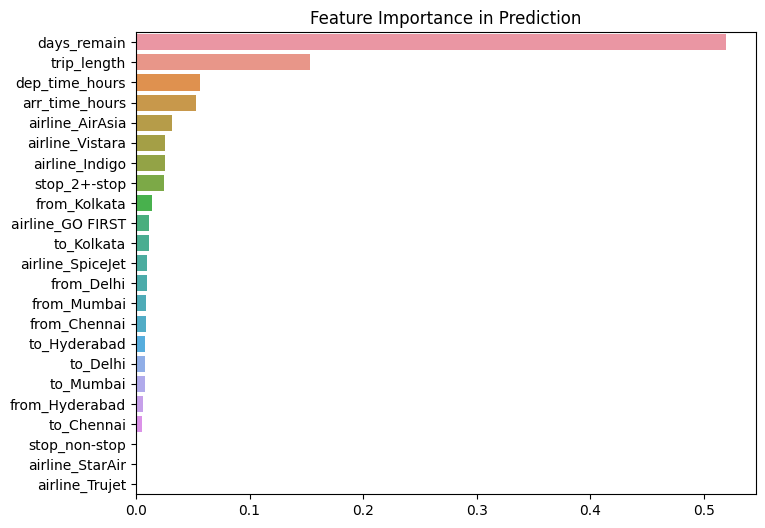

In [18]:
mrf0.plot_feature_importance()

As expected, the most important feature in this data is the time between the flight and when the price is quoted (i.e., days_remaining). Trip length is the second most import feature, indicating that passengers have a strong preference in the length of their trip. The time of the day for when the flight departs and arrives are also important, indicating passenger's strong preference in that as well.

Now train the fudicial XGBoost model and evaulate its performance, with a goal to benchmark agaist random forest

In [19]:
mxgb0 = XGBoost(x_train=X_train, y_train=y_train, feature_names=X.columns, n_estimators=200, max_depth=20)
mxgb0.train_model()
mxgb0.eval_model(X_test)
mxgb0.performance_stats(y_test)

The run time of 'train_model' is 49.942 seconds
Performance Statistics:
MAE: 497.38
RMSE: 1204.43
R² Score: 0.8958


Use cross validataion scores for initial benchmarking for overfitting and comparison

In [20]:
mrf0.cross_validation()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Cross-Validated MAE: 704.83
The run time of 'cross_validation' is 8:23.8


In [21]:
mxgb0.cross_validation()

Cross-Validated MAE: 543.73
The run time of 'cross_validation' is 3:31.6


Perform grid test on hyperparameter max_depth

In [22]:
xgb_mods = dict(mxdepth_20 = mxgb0)

for md in [10, 11, 12, 13, 15, 16, 18]:
    mxgb_i = XGBoost(x_train=X_train, y_train=y_train, feature_names=X.columns, n_estimators=200, max_depth=md)
    mxgb_i.train_model()
    mxgb_i.eval_model(X_test)
    mxgb_i.performance_stats(y_test, verbose=False)
    xgb_mods[f'mxdepth_{md}'] = mxgb_i

The run time of 'train_model' is 3.516 seconds
The run time of 'train_model' is 6.132 seconds
The run time of 'train_model' is 5.687 seconds
The run time of 'train_model' is 7.565 seconds
The run time of 'train_model' is 13.254 seconds
The run time of 'train_model' is 17.121 seconds
The run time of 'train_model' is 30.255 seconds


Plot MAE as a function of max_depth

Text(0.5, 0, 'Maximum Depth')

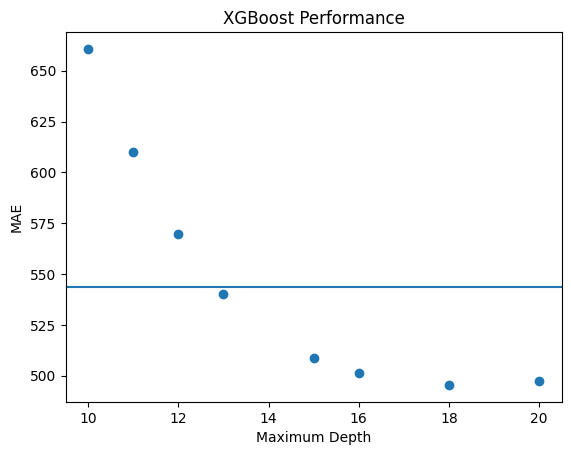

In [23]:
mae_vals = []
mxdep_vals = []

for key in xgb_mods:
    mod = xgb_mods[key]
    try:
        mae_vals.append(mod.mae)
        mxdep_vals.append(mod.max_depth)
    except:
        pass
        
plt.scatter(mxdep_vals, mae_vals)
plt.axhline(mxgb0.cv_mae)
plt.title("XGBoost Performance")
plt.ylabel("MAE")
plt.xlabel("Maximum Depth")

Maximum Depth of 13 seems to produce the best MAE that doesn't overfit significantly. Let's now plot its learningn curve to get a better sense of its performance

The run time of 'plot_learning_curve' is 2:09.6


<Axes: title={'center': 'Learning Curve'}, xlabel='Training Samples', ylabel='Score'>

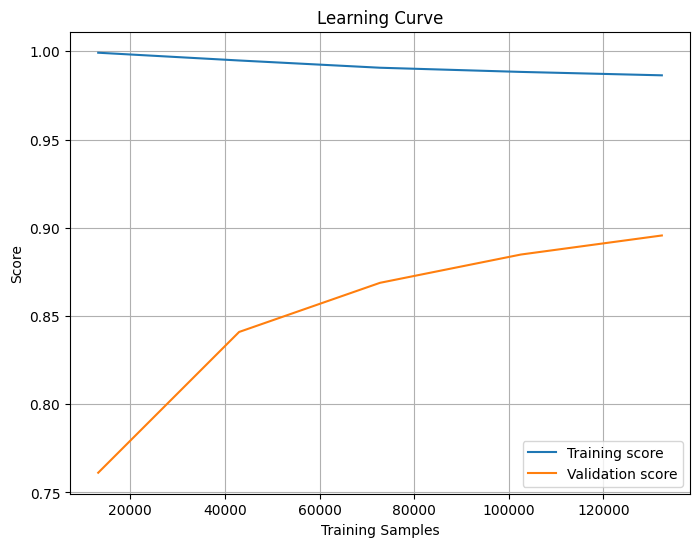

In [24]:
mxgb_best = xgb_mods['mxdepth_13']
mxgb_best.plot_learning_curve()

Calculate the cross validation MAE for the current best model for a new reference.

In [25]:
mxgb_best.cross_validation()

Cross-Validated MAE: 571.88
The run time of 'cross_validation' is 36.881 seconds


The higher new Cross-Validated MAE suggest that max depth of 13 may be over fitting a bit. Let's plot the learning curve of max_depth = 12 for a comparision.

The run time of 'plot_learning_curve' is 1:33.6


<Axes: title={'center': 'Learning Curve'}, xlabel='Training Samples', ylabel='Score'>

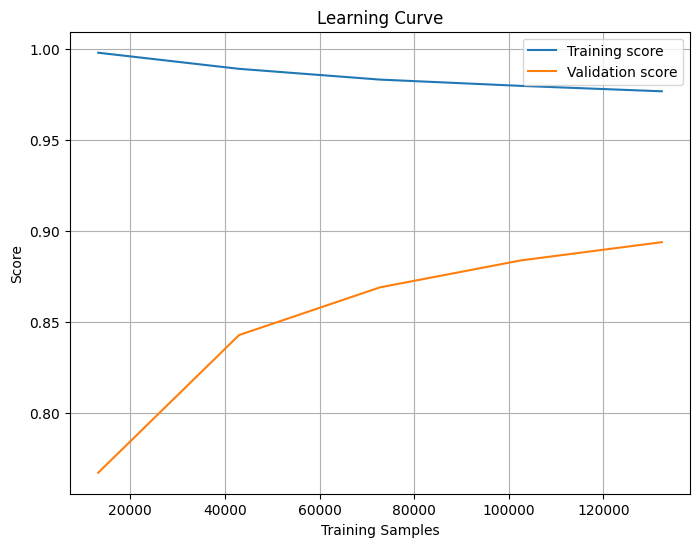

In [26]:
xgb_mods['mxdepth_12'].plot_learning_curve()

The learning curve for max_depth = 12 is very similar to  max_depth = 13, with maybe a faster drop off in training score, suggesting that max_depth = 12 (md12) is less overfitted and can still gain in performance with more training data. Let's plot md12's residuals for a sanity check.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


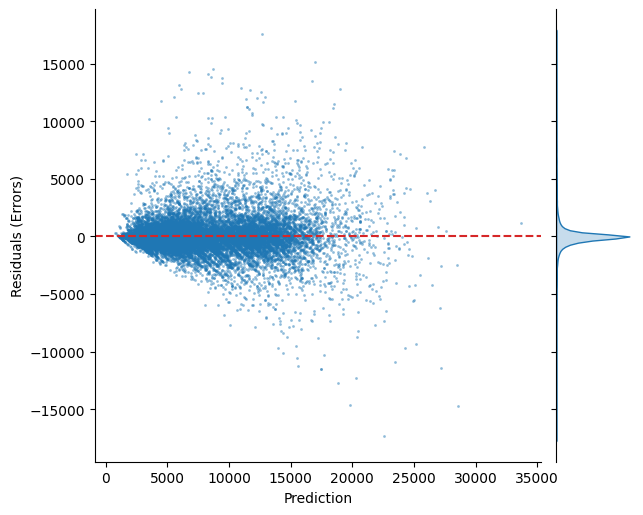

In [27]:
xgb_mods['mxdepth_12'].plot_residuals()

The residuals appears symmetrically distrubted around zero, and its KDE appears normally distrubted. md12 appears to be the best model rigth now without fine tuning